# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [112]:
# Update the PATH to include the user installation directory. 
# import os
# os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [113]:
# Install requirements
# !python -m pip install -r requirements.txt

## Imports

In [114]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [115]:
# Define transforms
transforms_custom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Create training set and define training dataloader
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms_custom)

# Create test set and define test dataloader
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms_custom)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?




-The ToTensor is to convert imgs to numbers.. it also separates imgs to 3 channels and convert them to tensors with intensity values [0-255].

-The Normalize is to normalize each channel making intensity values with zero mean this helps the model to be less sensitive to differences in intenisity changing.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [116]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


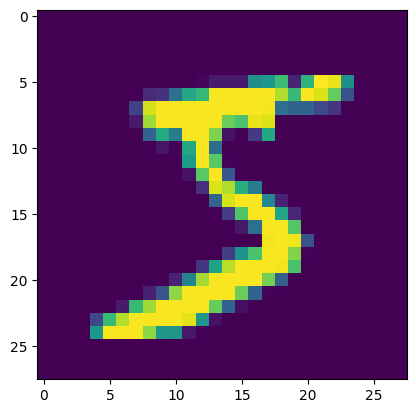

0


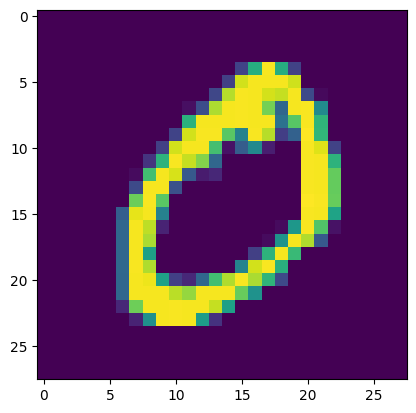

4


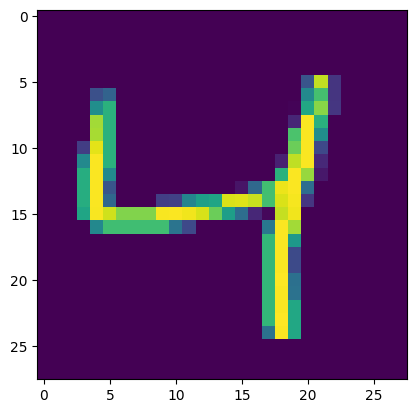

1


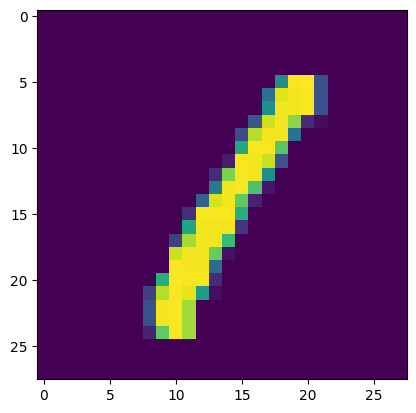

9


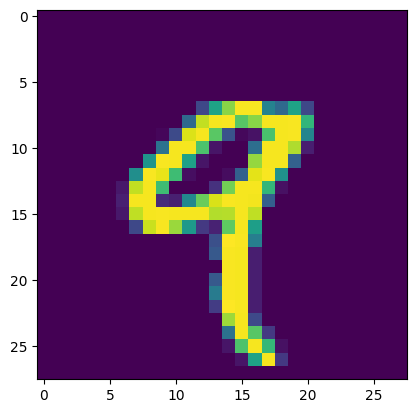

5


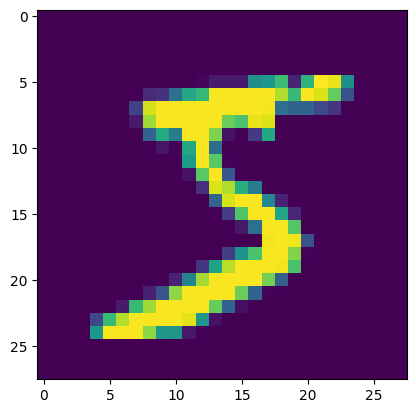

0


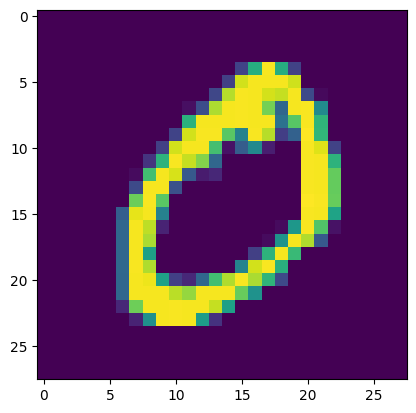

4


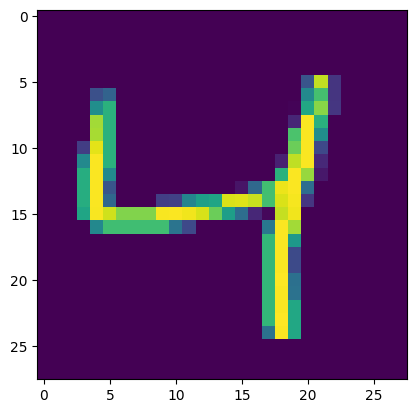

1


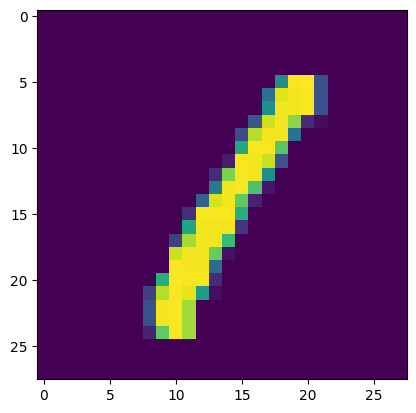

9


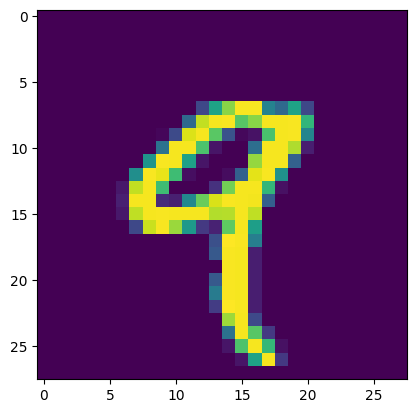

In [117]:
# Explore data
transformsView = transforms.Compose([
    transforms.ToTensor(),
])
viewset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformsView)
viewloader = torch.utils.data.DataLoader(viewset, batch_size=5,)
show5(viewloader)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,)
show5(trainloader)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [118]:
# Define network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [119]:
# loss function
criterion = nn.CrossEntropyLoss()

# network
net = Net()


# optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [120]:
# training loop
EPOCHS = 20

if torch.cuda.is_available():
    net = net.cuda()
    criterion = criterion.cuda()

train_loss_history = []
val_loss_history = []
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimizeY
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    print(f"Epoch {epoch} loss: {running_loss/len(trainloader)}")
    train_loss_history.append(running_loss/len(trainloader))

    # validation
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Epoch {epoch} validation accuracy: {correct/total}")
    val_loss_history.append(correct/total)

Epoch 0 loss: 0.6135427779656776
Epoch 0 validation accuracy: 0.8928
Epoch 1 loss: 0.33281486173893543
Epoch 1 validation accuracy: 0.9134
Epoch 2 loss: 0.28605113184832515
Epoch 2 validation accuracy: 0.9259
Epoch 3 loss: 0.24773866361443034
Epoch 3 validation accuracy: 0.934
Epoch 4 loss: 0.21562104204550703
Epoch 4 validation accuracy: 0.9407
Epoch 5 loss: 0.18927030170217474
Epoch 5 validation accuracy: 0.9461
Epoch 6 loss: 0.16885948499783557
Epoch 6 validation accuracy: 0.9491
Epoch 7 loss: 0.15326884606892757
Epoch 7 validation accuracy: 0.9521
Epoch 8 loss: 0.1409466173262038
Epoch 8 validation accuracy: 0.9545
Epoch 9 loss: 0.13078066661478358
Epoch 9 validation accuracy: 0.9569
Epoch 10 loss: 0.1219943438438659
Epoch 10 validation accuracy: 0.9585
Epoch 11 loss: 0.11439114185248284
Epoch 11 validation accuracy: 0.9599
Epoch 12 loss: 0.10800478619701685
Epoch 12 validation accuracy: 0.961
Epoch 13 loss: 0.10220545686860667
Epoch 13 validation accuracy: 0.9622
Epoch 14 loss: 0.

Plot the training loss (and validation loss/accuracy, if recorded).

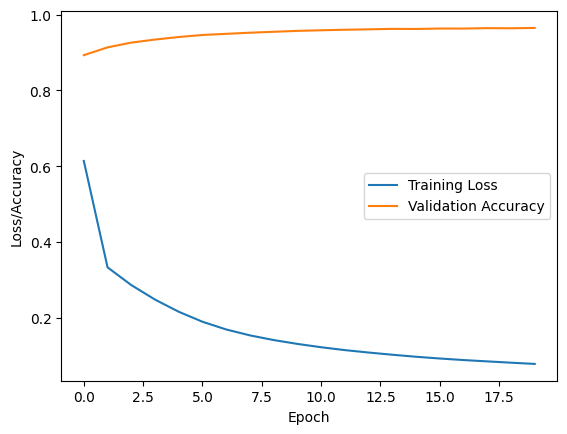

In [121]:
# plot the training loss and validation accuracy/loss
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.legend(["Training Loss", "Validation Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [122]:
# test the network

correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Final test accuracy: {correct/total}")


Final test accuracy: 0.9647


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

Epoch 0 loss: 0.6156453573006264
Epoch 0 validation accuracy: 0.8868
Epoch 1 loss: 0.3092311618810004
Epoch 1 validation accuracy: 0.911
Epoch 2 loss: 0.25060707739693056
Epoch 2 validation accuracy: 0.9272
Epoch 3 loss: 0.21706461703523677
Epoch 3 validation accuracy: 0.9359
Epoch 4 loss: 0.19563063124709942
Epoch 4 validation accuracy: 0.9384
Epoch 5 loss: 0.1824929290629448
Epoch 5 validation accuracy: 0.9448
Epoch 6 loss: 0.17085099497691114
Epoch 6 validation accuracy: 0.9408
Epoch 7 loss: 0.16773047683403847
Epoch 7 validation accuracy: 0.9466
Epoch 8 loss: 0.15480067260721897
Epoch 8 validation accuracy: 0.9467
Epoch 9 loss: 0.148988160189796
Epoch 9 validation accuracy: 0.9499
Epoch 10 loss: 0.143535107358339
Epoch 10 validation accuracy: 0.9529
Epoch 11 loss: 0.13537730034044448
Epoch 11 validation accuracy: 0.95
Epoch 12 loss: 0.132194472952409
Epoch 12 validation accuracy: 0.9549
Epoch 13 loss: 0.12896046911148315
Epoch 13 validation accuracy: 0.9513
Epoch 14 loss: 0.1237001

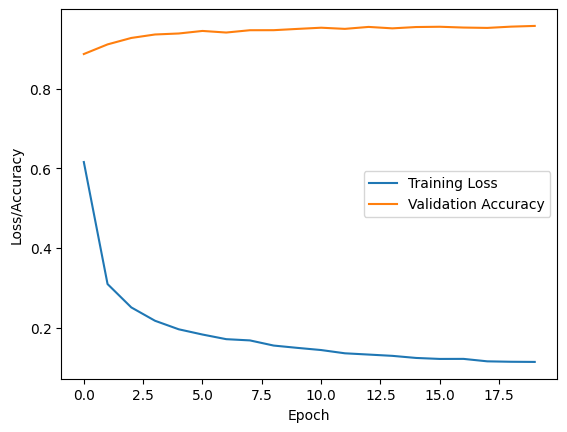

Final test accuracy: 0.9603


In [123]:
# imroving the network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# loss function
criterion = nn.CrossEntropyLoss()

# network
net = Net()


# optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# training loop

if torch.cuda.is_available():
    net = net.cuda()
    criterion = criterion.cuda()

train_loss_history = []
val_loss_history = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    
        running_loss = 0.0
        for i, batch in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
        print(f"Epoch {epoch} loss: {running_loss/len(trainloader)}")
        train_loss_history.append(running_loss/len(trainloader))
    
        # validation
        correct = 0
        total = 0
        net.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                if torch.cuda.is_available():
                    images = images.cuda()
                    labels = labels.cuda()
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f"Epoch {epoch} validation accuracy: {correct/total}")
        val_loss_history.append(correct/total)

# plot the training loss and validation accuracy/loss
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.legend(["Training Loss", "Validation Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()

# test the network

correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Final test accuracy: {correct/total}")




## Saving your model
Using `torch.save`, save your model for future loading.

In [124]:
# saving the model
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)
